<a href="https://colab.research.google.com/github/Mahdi-0599/NLP-HATESPEECH/blob/master/Copy_of_model_1_cnn_hate_speech_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Description
Dataset contains nearly 32K tweets which are labeled based on having racist or sexist content. We are going to analyse this dataset and tweets, and by the end, create a classification model to classify tweets.   
Each row in the dataset has 3 columns:
* `id`: Assigned ID to this tweet by Analytics Vidhya.
* `label`: Tweet label, 1 if tweet has hatred content and 0 otherwise.
* `tweet`: Tweet text.  

Dataset is provided by [Analytics Vidhya](http://https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/)  

In [ ]:
import numpy as np
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

data = pd.read_csv('../input/train.csv')
data

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


How are tweets spread among these 2 classes?

In [ ]:
import numpy as np
print("Hatred labeled: {}\nNon-hatred labeled: {}".format(
    (data.label == 1).sum(),
    (data.label == 0).sum()
))

Hatred labeled: 2242
Non-hatred labeled: 29720


In [ ]:
def eval_fun(labels, preds):
    labels = label.split(' ')
    preds = tweet.split(' ')
    rr = (np.intersect1d(label, tweet))
    precision = np.float(len(rr)) / len(tweet)
    recall = np.float(len(rr)) / len(label)
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        return (precision, recall, 0.0)
    return (precision, recall, f1)
print(1)

## Extracting features

#### Hashtags and mentions
We'll extract hashtags for each tweet as an extra column to explore them later.   
For user mentions, all of the usernames have been replaced with `'user'` so we can't get any data from it, we'll just remove mentions and keep the number of mentions in each tweet as an extra features for that tweet.  

In [ ]:
hashtags = data['tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
data.loc[:, 'hashtags'] = hashtags['hashtag']
data['hashtags'].fillna('', inplace=True)

data.loc[:, 'mentions'] = data['tweet'].str.count('@[a-zA-Z0-9_]+')

data.tweet = data.tweet.str.replace('@[a-zA-Z0-9_]+', '')

#### Removing anything but the words
Now we'll remove anything but the words (punctuations, numbers, etc). Note that this time we'll replace them with a blank space since it might be a `_` or `-` or a punctuation with no space from the next word and we don't want the words to join together.  

In [ ]:
data.tweet = data.tweet.str.replace('[^a-zA-Z]', ' ')

#### Lemmatization
We lemmatize tweets' words as we have the sentences and we can tag part of speeches, and will stem hashtags.  

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, FreqDist, word_tokenize

stemmer = SnowballStemmer('english')
lemmer = WordNetLemmatizer()

part = {
    'N' : 'n',
    'V' : 'v',
    'J' : 'a',
    'S' : 's',
    'R' : 'r'
}

def convert_tag(penn_tag):
    if penn_tag in part.keys():
        return part[penn_tag]
    else:
        return 'n'


def tag_and_lem(element):
    sent = pos_tag(word_tokenize(element))
    return ' '.join([lemmer.lemmatize(sent[k][0], convert_tag(sent[k][1][0]))
                    for k in range(len(sent))])
    

data.loc[:, 'tweet'] = data['tweet'].apply(lambda x: tag_and_lem(x))
data.loc[:, 'hashtags'] = data['hashtags'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


bild model cnn

In [ ]:
texts = np.array(data['tweet'])
labels = np.array(data['label'])

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
samples = texts.shape[0]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen)
print(data.shape)
print(labels.shape)


Using TensorFlow backend.


(31962, 100)
(31962,)


In [ ]:
x_train = data[:7925]
y_train = labels[:7925]

x_val = data[7925:8925]
y_val = labels[7925:8925]

x_test = data[8925:]
y_test = labels[8925:]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
##




(7925, 100)
(1000, 100)
(23037, 100)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional
model = Sequential()
model.add(Embedding(1+len(word_index), 16))
model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.5, return_sequences=True)))
model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.5)))
model.add(Dense(1, activation='sigmoid'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          545360    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          12544     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 582,801
Trainable params: 582,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train,y_train,epochs=20,batch_size=64,validation_data=(x_val,y_val))


Train on 7925 samples, validate on 1000 samples
Epoch 1/20
7925/7925 [==============================] - 41s 5ms/step - loss: 0.2744 - acc: 0.9258 - val_loss: 0.2328 - val_acc: 0.9340
Epoch 2/20
7925/7925 [==============================] - 38s 5ms/step - loss: 0.1918 - acc: 0.9334 - val_loss: 0.1497 - val_acc: 0.9570
Epoch 3/20
7925/7925 [==============================] - 40s 5ms/step - loss: 0.1318 - acc: 0.9544 - val_loss: 0.1485 - val_acc: 0.9550
Epoch 4/20
7925/7925 [==============================] - 37s 5ms/step - loss: 0.1080 - acc: 0.9647 - val_loss: 0.1508 - val_acc: 0.9550
Epoch 5/20
7925/7925 [==============================] - 38s 5ms/step - loss: 0.0893 - acc: 0.9722 - val_loss: 0.1500 - val_acc: 0.9520
Epoch 6/20
7925/7925 [==============================] - 37s 5ms/step - loss: 0.0809 - acc: 0.9732 - val_loss: 0.1456 - val_acc: 0.9520
Epoch 7/20
7925/7925 [==============================] - 38s 5ms/step - loss: 0.0709 - acc: 0.9768 - val_loss: 0.1568 - val_acc: 0.9510
Epoch 8

In [ ]:
def cnfmatrix(y_test,results):
    fp = 0.0
    fn = 0.0
    tp = 0.0
    tn = 0.0
    t = 0.0
    n = 0.0
    results.shape
    for i in range(results.shape[0]):
        if y_test[i]==1 and results[i]==1:
            tp+=1
            t+=1
        elif y_test[i]==1 and results[i]==0:
            fn+=1
            t+=1
        elif y_test[i]==0 and results[i]==1:
            fp+=1
            n+=1
        elif y_test[i]==0 and results[i]==0:
            tn+=1
            n+=1
    print(tp/results.shape[0],fp/results.shape[0])
    print(fn/results.shape[0],tn/results.shape[0])
    Precision  = tp/(tp+fp)
    Recall = tp/(tp+fn)
    print("Precision: ",Precision,"Recall: ",Recall)
    f1score = (2*Precision*Recall)/(Precision+Recall)
    print("f1score: ",f1score)
    print("accuracy: ",(tp+tn)/results.shape[0])
    print("hate_acc: ", (tp)/t)
    print("non_hate_acc: ", (tn)/n)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
results = []
for prediction in predictions:
    if prediction < 0.5:
        results.append(0)
    else:
        results.append(1)
        
results = np.array(results)

In [ ]:
cnfmatrix(y_test, results)


0.035247645092677 0.019750835612275905
0.03529105352259409 0.909710465772453
Precision:  0.6408839779005525 Recall:  0.4996923076923077
f1score:  0.5615491009681881
accuracy:  0.94495811086513
hate_acc:  0.4996923076923077
non_hate_acc:  0.9787502335139174


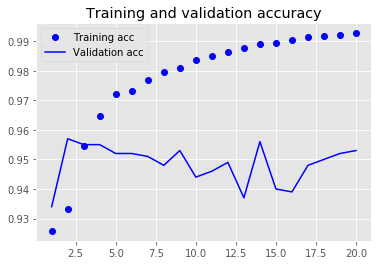

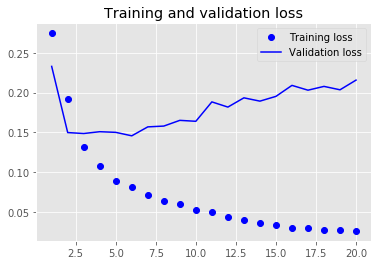

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
def test(model):
    f1_score = lambda precision, recall: 2 * ((precision * recall) / (precision + recall))
    nexamples, recall, precision = model.test('fasttext.test')
    print (f'recall: {recall}' )
    print (f'precision: {precision}')
    print (f'f1 score: {f1_score(precision,recall)}')
    print (f'number of examples: {nexamples}')
print(1)

1


In [ ]:
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])#
#history = model.fit(x_train,y_train,epochs=20,batch_size=512,validation_data=(x_val,y_val))

#### Frequent words
Now let's see what words and hashtags are the most frequenst in hate tweets and in total.

In [ ]:
##from wordcloud import WordCloud, STOPWORDS
##stopwords = STOPWORDS.add('amp')
##traindata = ['tweet', 'label']
##all_words = ' '.join('tweet', 'label')
##hatred_words = ' '.join(data[data.label == 1].tweet.values)

##plt.figure(figsize=(16, 8))

##cloud1 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(all_words)
##plt.subplot(121)
##plt.imshow(cloud1, interpolation="bilinear")
#plt.axis("off")
#plt.title('All tweets', size=20)

##cloud2 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(hatred_words)
##plt.subplot(122)
##plt.imshow(cloud2, interpolation="bilinear")
##plt.axis("off")
##plt.title('Hatred tweets', size=20)
##plt.show()

#### Hashtags
Now let's see which hashtags are used the most in hatred tweets and in total.

In [ ]:
##all_hashtags = FreqDist(list(' '.join(data.hashtags.values).split())).most_common(10)
##hatred_hashtags = FreqDist(list(' '.join(data[data.label==1].hashtags.values).split())).most_common(10)
##plt.figure(figsize=(14, 6))
##ax = plt.subplot(121)
##pd.DataFrame(all_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
##plt.xlabel('# occurrences')
##plt.title('Hashtags in all tweets', size=13)
##ax = plt.subplot(122)
##pd.DataFrame(hatred_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
##plt.xlabel('# occurrences')
##plt.ylabel('')
##plt.title('Hashtags in hatred tweets', size=13)
##plt.show()

#### Mentions
Let's see how many mentions are there in total and if they can be of any use

In [ ]:
##print("Number of mentions: {}\nNumber of tweets having a mention: {}\nCorrelation with label: {}".format(
##    data.mentions.sum(),
##    len(data[data.mentions > 0]),
##    np.corrcoef(data.mentions, data.label)[0][1]
##))

There is no meaningful relation between number of mentions and it looks like there is not a correlation either. So we'll remove number of mentions and won't use it as a feature.  

In [ ]:
##data.drop('mentions', axis=1, inplace=True)

#### Tfidf vectorizing
Now we use the frequency of each word in tweets as our features

In [ ]:
##from sklearn.feature_extraction.text import TfidfVectorizer
##from nltk.corpus import stopwords

##vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), min_df=10)
##features = vectorizer.fit_transform(data.tweet)

## Classifying
We'll build a SVC and a LogsiticRegression model for classifying our tweets.

In [ ]:
##from sklearn.linear_model import LogisticRegression
##from sklearn.svm import SVC
##from sklearn.model_selection import train_test_split, GridSearchCV
##from sklearn.metrics import f1_score

##x_train, x_test, y_train, y_test = train_test_split(features, data.label)

#### Logistic Regression

In [ ]:
##params = {'penalty': ['l1', 'l2'], 'C': [3, 10, 30, 100, 300]}
##lrmodel = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=150), param_grid=params, scoring='f1', cv=5, n_jobs=-1)
##lrmodel.fit(X_train, y_train)
##print("Best parameters found were {} with F1 score of {:.2f}".format(
##    lrmodel.best_params_,
##    lrmodel.best_score_
##))
##probas = lrmodel.predict_proba(X_test)
##thresholds = np.arange(0.1, 0.9, 0.1)
##scores = [f1_score(y_test, (probas[:, 1] >= x).astype(int)) for x in thresholds]
##plt.plot(thresholds, scores, 'o-')
##plt.title("F1 score for different thresholds")
##plt.ylabel("Score")
##plt.xlabel("Threshold")
##plt.show()

Best threshold found for our model is 0.4 so we will label any tweet with probability higher than or equal to 0.4 as hate tweet.

#### SVC

In [ ]:
##params = {'C': [1000, 3000, 9000, 15000]}
##svc = GridSearchCV(SVC(kernel='rbf', gamma='auto'), param_grid=params, scoring='f1', cv=3, n_jobs=-1)
##svc.fit(X_train, y_train)
##print("Best parameters found were {} with F1 score of {:.2f}".format(
##    svc.best_params_,
##    svc.best_score_
##))
##predictions = svc.predict(X_test)
##print("\nF1 test score for SVC: {:.2f}".format(f1_score(y_test, predictions)))

## Conclusion
We saw some of the most common words and hashtags in general and in racist/sexist tweets, extracted features by counting word tokens and Tfidf weighting them. We used unigrams, bigrams and trigrams as tokens.   
Finally, we built a logistic regression model and a support vector classifier to classify future tweets in these 2 classes.  